In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

In [2]:
ssh_hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")
ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

In [4]:
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 

## Processing

In [5]:
ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 0, np.nan).load()

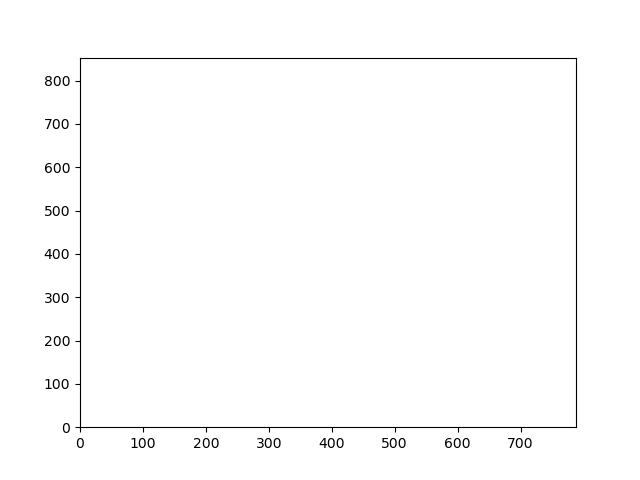

In [6]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked)
plt.show()

In [16]:
ssh_hf_1h_masked_coarsen = ssh_hf_1h.coarsen(x=4,y=4,boundary='trim').mean()

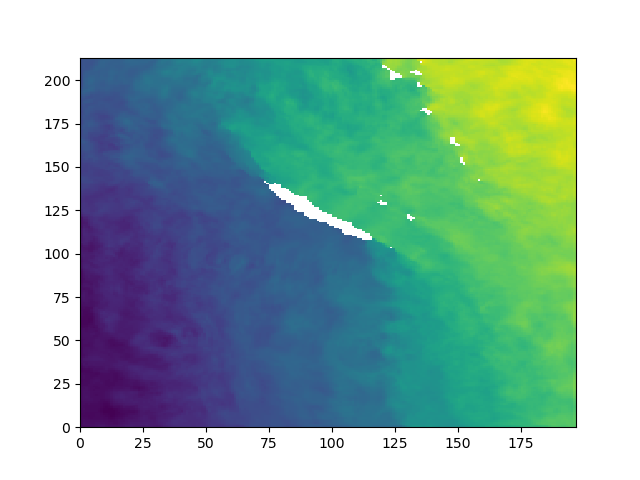

In [17]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked_coarsen['ssh_hf'])
plt.show()

In [7]:
# Define the axes correctly using pyinterp.core.Axis
x_axis = pyinterp.core.Axis(ssh_hf_1h_masked.x.values, is_circle=True)
y_axis = pyinterp.core.Axis(ssh_hf_1h_masked.y.values, is_circle=True)

In [9]:
ssh_hf_1h_masked

<xarray.DataArray 'ssh_hf' (y: 853, x: 788)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat      (y, x) float32 3MB -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon      (y, x) float32 3MB 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x

In [10]:
grid = pyinterp.Grid2D(y_axis, x_axis, ssh_hf_1h['ssh_hf'].values)

In [11]:
has_converged, filled = fill.gauss_seidel(grid,num_threads=16)

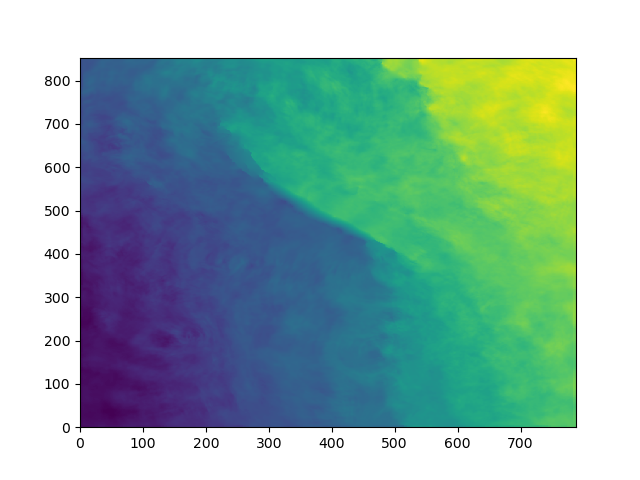

In [12]:
plt.figure()
plt.pcolormesh(filled)
plt.show()

In [14]:
def extend(filled,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

NameError: name 'ssh_extended' is not defined

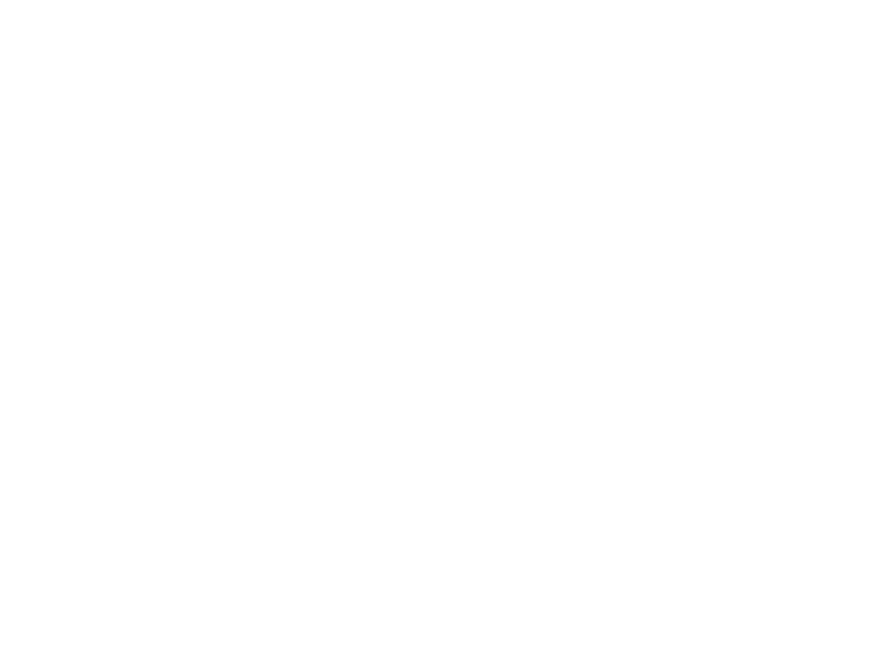

In [15]:
plt.figure(figsize=(8.96, 6.72)) #Default 6.4, 4.8 #multipliedr by 1.4
new_cmap = cmocean.cm.curl.copy()
new_cmap.set_bad('black', 1.) # Set NaN values to black in the new colormap
plt.pcolormesh(ssh_extended, cmap=new_cmap, vmin=-1, vmax=1)
plt.colorbar(label='Height (m)')
plt.title(r'Extended $\eta^{HF}$')
plt.xlabel('Extended x dimension')
plt.ylabel('Extended y dimension')
ax = plt.gca()  # Get the current Axes instance on the current figure
#ax.set_aspect('equal', adjustable='box')
plt.show()

In [19]:
print("Shape of filled array:", filled.shape)


Shape of filled array: (213, 197)


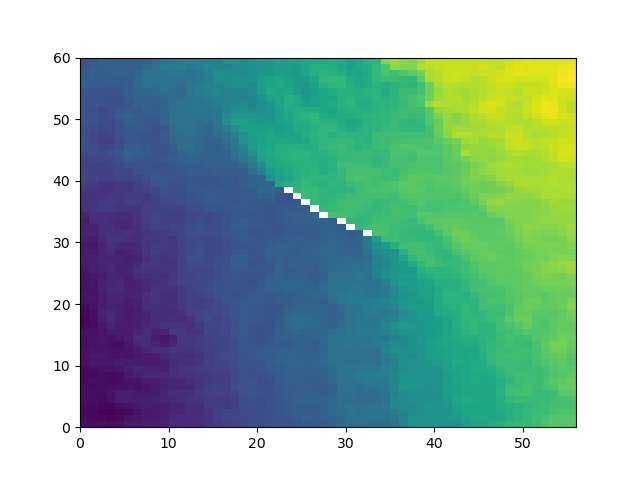

In [38]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_coarsen["ssh_hf"])
plt.show()

In [24]:
ssh_hf_1h_coarsen = ssh_hf_1h_coarsen.chunk({'time_counter':1})

ValueError: chunks keys ('time_counter',) not found in data dimensions ('y', 'x')

In [ ]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [ ]:
plt.figure(figsize=(8.96, 6.72)) #Default 6.4, 4.8 #multipliedr by 1.4
new_cmap = cmocean.cm.curl.copy()
new_cmap.set_bad('black', 1.) # Set NaN values to black in the new colormap
plt.pcolormesh(extended_ssh_hf, cmap=new_cmap, vmin=-1, vmax=1)
plt.colorbar(label='Height (m)')
plt.title(r'Extended $\eta^{HF}$')
plt.xlabel('Extended x dimension')
plt.ylabel('Extended y dimension')
ax = plt.gca()  # Get the current Axes instance on the current figure
#ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

In [ ]:
def gaspari_cohn(array,distance,center):
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [ ]:
# Ensure nx and ny are integers
nx = int(ssh_hf_1h['ssh_hf'].shape[1])
ny = int(ssh_hf_1h['ssh_hf'].shape[0])

In [ ]:
# Checking if grid is constant in x and y dimensions (it is constant)

dx = ssh_hf_1h['lon'].diff(dim='x')  # Change in longitude along x-axis
dy = ssh_hf_1h['lat'].diff(dim='y')  # Change in latitude along y-axis

std_dx = dx.std().values  # Standard deviation of dx
std_dy = dy.std().values  # Standard deviation of dy

print("Standard deviation of dx:", std_dx)
print("Standard deviation of dy:", std_dy)

# Define a small threshold, e.g., a very small degree difference
threshold = 0.01  # or another appropriate small value based on your domain knowledge

if std_dx < threshold and std_dy < threshold:
    print("Grid is regular in both x and y dimensions.")
else:
    print("Grid is irregular in at least one dimension.")

In [ ]:
# If it is regular, we can proceed with the following steps:
# Compute mean of dx and dy and convert to plain numbers
dx_mean = float(dx.mean().values)  # Ensure this is a scalar float
dy_mean = float(dy.mean().values)  # Ensure this is a scalar float

In [ ]:
kx = np.fft.fftfreq(3*nx,dx_mean) # km
ky = np.fft.fftfreq(3*ny,dy_mean) # km
k, l = np.meshgrid(kx,ky)
wavenum2D = np.sqrt(k**2 + l**2)

lambda_bar = 400
lowpass_bar = lowpass(lambda_bar,nx,ny,wavenum2D)

window = create_spatial_window(nx,ny)

# Now pass this array to the extend function
ssh_extended = extend(ssh_hf_1h['ssh_hf'], nx, ny)

# Use ssh_extended in further calculations
ssh_extended = ssh_extended * window
ssh_freq = np.fft.fft2(ssh_extended)
ssh_freq_filtered = lowpass_bar * ssh_freq
ssh_filtered = np.real(np.fft.ifft2(ssh_freq_filtered))[ny:2*ny, nx:2*nx]


In [ ]:
ssh_extended

In [ ]:
# First, ensure we're plotting the original or meaningful data
# Let's plot 'ssh_filtered' if you meant to show the results of your processing
plt.figure()
ax = plt.axes()  # Creates a new axes object

# You need to ensure that 'lon' and 'lat' are correctly shaped; if they are 1D, use meshgrid
lon, lat = np.meshgrid(ssh_hf_1h['lon'].values, ssh_hf_1h['lat'].values)

# Now, use 'pcolormesh' to plot the filtered SSH data, assuming 'ssh_filtered' is the result you want to see
pcolormesh = ax.pcolormesh(lon, lat, ssh_filtered, cmap='viridis')
plt.colorbar(pcolormesh, ax=ax, orientation='vertical', label='SSH (m)')
ax.set_title("Filtered Sea Surface Height")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
